# Scope analysis 

### Imports and other required functions

In [3]:
#Import needed libraries
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv
import datetime
import os,platform
from scipy.optimize import curve_fit
import scipy
from scipy.fft import fft, rfft, irfft,ifft,fftfreq
from scipy.signal import argrelextrema
from scipy.stats import norm
from lmfit.models import SkewedGaussianModel


#varible for determining the lab pc or other pc, Check if windows or not, then try to grab pc name
pcname=""
if platform.system() == "Windows":
    pcname=platform.uname().node
else:
    try:
        pcname=os.uname()[1]
    except:
        print("Issue with finding pc name")

env_var_wavefromloc ="" #varible for location of waveform data. 
data_dir_mod_old="" #varible for small difference in storage managment between pc 1 and 2
if pcname=='PHYS-PSB02802': #Lab pc 2, (Labview pc)
    env_var_wavefromloc ="A:/DATA/waveforms/"
    env_var_waveformloc_old="C:/Users/KK_Lab28_1/Documents/Waveforms/"
    data_dir_mod_old=""

elif pcname=="PHYS-PSB02801": #Lab pc 1, (solidworks pc)
    env_var_wavefromloc ="data/waveforms/" #This is true for Jason's work atm (June 10th) Needs Updateing to global or user friendly verison
    data_dir_mod_old="/"
##############################

waveform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

waveform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc


#Read in runlist and change cols to numbers
def ReadRunlist(filename="C:/Users/jasonbane/Desktop/nexo_code/Run Data (GUI v1)/RunList.csv"):
    return pd.read_csv(filename,index_col=False)

Runlist_DF = ReadRunlist()
Runlist_DF["RN"]=Runlist_DF["Run No."]
number_cols=["Anode V.","Anode Grid V.","Cathode V.","Cathode Grid V.","Drift Length"]
Runlist_DF[number_cols] = Runlist_DF[number_cols].apply(pd.to_numeric)

# Read in Drift stack measurment database for drift, ext, col lengths and errors
Distance_Database=pd.read_csv("C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/CellDistanceDataBase.csv")
Distance_Database["Date"] = Distance_Database["Date"].astype(str)
Distance_Database["Date"] = pd.to_datetime(Distance_Database["Date"])


# Add in distance to run list and calc fields
if 1==1:
#def runlist_distance_fix():
    global Runlist_DF
    global Distance_DataBase

    skip=0
    for i,run in enumerate(Runlist_DF["Run No."][skip:]):
        
        Date = pd.to_datetime(Runlist_DF["Date"].iloc[i+skip],format='%Y%m%d')
        # Date = datetime.datetime(Date)
        
        DF =Distance_Database[Distance_Database["Date"]<= Date].iloc[0]
        

        for key in DF.keys()[1:]:
            
            Runlist_DF.loc[i+skip,key] = DF[key]



Runlist_DF["Drift Field"] = (Runlist_DF["Cathode Grid V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Drift Length"]/10.0)
Runlist_DF["Extraction Field"] = (Runlist_DF["Cathode V."] - Runlist_DF["Cathode Grid V."])/(Runlist_DF["Extraction Distance"]/10.0)
Runlist_DF["Collection Field"] = (Runlist_DF["Anode V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Collection Distance"]/10.0)
Runlist_DF["Drift Distance"] = Runlist_DF["Drift Length"] + Runlist_DF["Extraction Distance"] + Runlist_DF["Collection Distance"]
Runlist_DF["Drift Distance Error"] = np.sqrt(Runlist_DF["Drift Length Error"]**2 + Runlist_DF["Collection Distance Error"]**2 + Runlist_DF["Extraction Distance Error"]**2)

#Bg database
bgdb=pd.read_csv("C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/bg_db.csv")


#make blank dataframe for background subtraction debugging
blankBG_DF= pd.DataFrame({"Avg Anode":[0]*50000})

### Collection of old data

In [4]:

# Njoya et. al., NIMA 972,21  2020

#Njoya  velocties vs field [mm/us]. [V/cm]
njyl=np.array([1.24,1.31,1.36,1.4,1.64,1.79,1.9,1.99,2.154,2.2685])
njxl=np.array([70,80,90,100,200,300,400,500,750,1000])

njoya_x=njxl
njoya_y=njyl


# Phys. Rev. 166, 871 - data

# L. S. Miller, S. Howe, and W. E. Spear
# Phys. Rev. 166, 871 – Published 15 February 1968
ChT_Vs=np.array([41.368,128.825, 194.984, 395.063, 579.874, 794.328])
ChT_dv= np.array([0.763 ,1.416, 1.59, 1.813, 1.899, 2.052])


# J. Yoo and W.F. Jaskierny 2015 JINST 10 P08011    --Data
AAA = [200, 0.148 , 0.003, 0.181 , 0.003, 1.22,
250, 0.157 , 0.004, 0.200 , 0.004, 1.27,
300, 0.162 , 0.003, 0.227 , 0.004, 1.40,
350, 0.166 , 0.003, 0.245 , 0.005, 1.48,
400, 0.167 , 0.003, 0.255 , 0.004, 1.53,
450, 0.174 , 0.004, 0.266 , 0.004, 1.53,
500, 0.177 , 0.003, 0.274 , 0.004, 1.55,
550, 0.180 , 0.004, 0.288 , 0.005, 1.60,
600, 0.184 , 0.003, 0.302 , 0.006, 1.64,
650, 0.186 , 0.003, 0.325 , 0.006, 1.74,
700, 0.189 , 0.006, 0.343 , 0.005, 1.82,
750, 0.191 , 0.003, 0.357 , 0.005, 1.87,
800, 0.193 , 0.003, 0.382 , 0.007, 1.98,
850, 0.194 , 0.003, 0.390 , 0.007, 2.01,
900, 0.193 , 0.003, 0.397 , 0.006, 2.05]


JINST_2015_dict={}

vs=[]
lds=[]
lds_e=[]
for i in np.arange(0,15,1):
    vs.append(AAA[i*6])
    lds.append(AAA[i*6+1]*10)
    lds_e.append(AAA[i*6+2])
JINST_2015_dict["Voltage"]=vs
JINST_2015_dict["DriftSpeed"]=lds
JINST_2015_dict["Error"]=lds_e


#J. B. Albert et al. (EXO-200 Collaboration) Phys. Rev. C 95, 025502 – Published 14 February 2017
EXO200= np.array([ [614.706, 565.686, 378.431, 186.275, 74.51, 38.235, 19.608],
          [1.981, 1.946, 1.784, 1.576, 1.271, 0.899, 0.484]])






### Functions for fitting, Runinfo and waveform gathering

In [5]:
# Gaussian function definition
def congaussian(x,A,t,sigma):
    return A * np.exp(-(x-t)/10)* np.exp(-(x-t)**2/(2*sigma**2))

def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
def logarithmic_model(x, a, b):
    return a * np.log(b * x)

def dg(x,a,mu_a,sigma_a,m,b):
    return a * np.exp(-(x - mu_a) ** 2 / (2 * sigma_a ** 2)) +   (m + x*b)

def sin_linear(x, amplitude, frequency, phase, slope, intercept):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + slope * x + intercept
def sin(x, amplitude, frequency, phase ):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)


# Define a sinusoidal function for fitting
def sinusoidal(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset


# Define the skewed Gaussian function
def skewed_gaussian(x, alpha, mu, sigma, amplitude):
    # Standard normal PDF
    pdf = amplitude * (2 / sigma) * norm.pdf((x - mu) / sigma)
    # Skew factor
    cdf = norm.cdf(alpha * (x - mu) / sigma)
    return pdf * cdf

def errfunc(x, a, b, z, f):
    return a * scipy.special.erf((x - z)*f) + b

#Function to retrieve run list information
def GetRunInfo(runnumber, old=False):
    global Runlist_DF
    if old:
        print("not set up yet")
        return -1
    
    DF=Runlist_DF.query('`Run No.`== %f'%(runnumber))

    if len(DF)==0:
        print("That run is not in the list")
        return 0
    else:
        return DF
    

def GetBGRun(run):
    global bgdb
    try:
        return bgdb.query("run==%i"%(run)).iloc[0]["background"]
    except:
        return -1

In [6]:
locations= ["C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/",r"\\172.24.54.234/NAS-Lab28/Data/"]


def find_the_file(RN=596):
    global locations
    global waveform_path
    waveformpath=waveform_path
    RI = GetRunInfo(RN)
    if type(RI) == type(0) :
        return 0
    RI = RI.iloc[0]

    
    runstr = f"{RN}".zfill(5)

    dir_strs= [f"{RI.Date}-{runstr}",f"{RI.Date}/{RI.Date}-{runstr}"]
    located=0
    for loc in locations:
        for dir_str in dir_strs:
            fullpath= loc + dir_str

            if os.path.exists(fullpath):
                waveformpath=fullpath
                located=1

    if located == 0:
        return 0
    else :
        return waveformpath



### Get Waveform


In [7]:
def GetWaveForm(runnumber,wavenumber=9):
    global waveform_path
    RI = GetRunInfo(runnumber) 
    RN=runnumber
    if type(RI)==type(0): #Make sure run is in runlist
        return 0
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="%05i"%(runnumber)


    # For left PC
    #waveform_dir=waveform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveformpath=find_the_file(RN)
    waveform_dir = waveformpath


    waveform_wavenumber="%s"%(wavenumber)

    waveform_filename=waveform_date+"-"+runnumber+"_"+"*"+waveform_wavenumber
    waveform_fullpath_wild=waveform_dir+"/"+waveform_filename+".csv"
    try: 
        waveform_fullpath=glob.glob(waveform_fullpath_wild )[-1].replace("\\","/")
    except:
        waveform_fullpath=glob.glob(waveform_dir+"/"+waveform_date+"-"+runnumber+"_"+"*" )[-1].replace("\\","/")
    
    if os.path.exists(waveform_fullpath):
        # Grab the second line and define the units of each column
        unit_line=open(waveform_fullpath).readlines()[1]
        units=unit_line.replace("(","").replace(")","").strip().split(",")
        #Build DF from csv
        DF=pd.read_csv(waveform_fullpath,skiprows=[1])
        # Convert to ms and mV
        for i,key in enumerate(DF.keys()):
            if units[i] == "V":
                DF[key]=DF[key]*1000 
            if units[i] == "ms":
                print("time convertion")
                DF[key]=DF[key]*1000 
        # rename columns
        DF=ReNameCols(DF)

        #if checkforshit(DF) == 0:
        #    return DF
        
            
        return DF

        
    else: # Did not find file
        print("Issue with file")
        return 0




def checkforshit(DF):
    bad=0
    for key in DF.keys():
        if type(DF[key].iloc[1] == type("str")):
            bad =key
        else:
            continue

    return bad
    

# this should correct the colomn names of the avg cath and anode. need to add incorrect options to list
def ReNameCols(DF):
    chann_name_options=[["Avg UV","Avg Anode"],
                        ['Average Cathode (2)', 'Average Anode (2)'],
                        ['average(Cathode)', 'average(Anode)']]
    Correct_names=["Avg Cathode","Avg Anode"]
    keys=DF.keys()
    if Correct_names[0] in keys and Correct_names[1] in keys:
        return DF
    for chan_options in chann_name_options:
        if chan_options[0] in keys:
            DF =DF.rename(columns={chan_options[0]: Correct_names[0]})
        if chan_options[1] in keys:
            DF =DF.rename(columns={chan_options[1]: Correct_names[1]})

    return DF






## Building fitting and plotting functions for a run

In [8]:
def GetSinBG(x_data,y_data,time_start=0,time_stop=10,stepsize=100,debug=10,plot=True):
    
    x_fit=[]
    y_fit=[]
    
    if len(x_data) <=1 or len(y_data)<=1 or len(x_data) != len(y_data):

        print("X and Y need to be equal in length and need two more data points")
        print(" X: ", len(x_data), " Y :" ,len(y_data))
        return np.zeros(len(x_data)),np.zeros(len(y_data))
    
    if plot: sin_figure, sin_ax =plt.subplots(figsize=(5,4))

    # Determine fitting limits
    time_resolution= x_data[1] - x_data[0]
    index_start = int(time_start/time_resolution)
    index_stop = int(time_stop/time_resolution)
    if debug>=10: print("Start ",time_start,index_start," stop ",time_stop,index_stop)
    
    if plot:sin_ax.errorbar(x_data,y_data,alpha=0.75,
    linestyle=(0, (5, 1)),c="gray",label="Data")



    # smooth out the data
    smooth_slice=slice(int(stepsize/2),-(int(stepsize/2)+1))
    smooth_ydata=np.convolve(y_data,
     np.ones(stepsize)/stepsize,mode="same")[smooth_slice]
    smooth_xdata=x_data[smooth_slice]
    if plot:sin_ax.errorbar(smooth_xdata,smooth_ydata,
    linestyle=(0, (5, 1)),label="Smooth Data")

    # Prepare for fit
    x_fitdata=smooth_xdata[index_start:index_stop-int(stepsize/2)]
    y_fitdata=smooth_ydata[index_start:index_stop-int(stepsize/2)]
    #if plot:sin_ax.errorbar(x_fitdata,y_fitdata,fmt=":",label="Fit Data")

    p0=[max(y_fitdata)-min(y_fitdata),0.15,0.1,-0.1,2]
    bounds=[-1,0.001,-np.pi,-5,-10],[p0[0]+1,1.5,np.pi,5,1000]
    
    if debug>=10:
        print("Fit P0",p0)
        print("Bounds",bounds)
    params, covariance = curve_fit(sin_linear, 
        x_fitdata, y_fitdata,p0=p0,bounds=bounds)

    if debug >=5:
        print("Parameters", params)
    if debug>=10: print("Covariance",covariance)
    
    x_fit=smooth_xdata
    y_fit=sin(x_fit,params[0],params[1],params[2])
    if plot:
        sin_ax.errorbar(x_fitdata,sin_linear(x_fitdata,*params),
        linestyle="--",label="Fit Results")
        sin_ax.errorbar(x_fit,y_fit+params[4],linestyle="--",label="Sin Fit")
        sin_ax.errorbar(x_fit[::stepsize],(smooth_ydata-y_fit)[::stepsize],
                        color="black",fmt="-.",linewidth=0.51,label="Subtracted")

    y_fit_Stddev=sin_linear(x_fitdata,*params)
    dev = np.sqrt(np.sum(abs(y_fit_Stddev-y_fitdata)**2)/len(y_fit))
    if debug >=5: print("Fit deviation from fitting data", dev)
    if dev>1:
        print("\t\t!!!!!!WARNING!!!!!!!!!  Issue with sin fit Large Deviation")
    #print((y_fit_Stddev-y_fitdata)/y_fitdata )
    if plot:
        sin_ax.grid()
        sin_ax.legend()
        #plt.xlim(time_start-12,time_stop-8)
        #plt.ylim(params[4] + params[3]*time_stop,params[4]*1.1)

    return params,covariance

## Analyze run

In [28]:
def AnalyzeRun(runs=[200],stepcounts=[100],diffsizes=[200],debug=1,plot=True,savefig=True):
    

    anode_delay=[]
    cathode_delay=[]
    drift_field_list=[]
    k=0
    ana_list=[]
    if type(runs)==type(1):
        runs=[runs]
    if type(stepcounts)==type(1):
        stepcounts=[stepcounts]
    if type(diffsizes)==type(1):
        diffsizes=[stepcounts]
    
    for run in runs:
        for diffsize in diffsizes:
            for stepcount in stepcounts:
            

                analysis_dict={}
                bg_run=GetBGRun(run)
                if debug >= 1: 
                    print("Run " , run, "  BG- ", bg_run)
                    print("Stepsize %i , DiffSize %i"%(stepcount,diffsize))
                
                
                # Grab the main and background waveforms
                try:
                    DF=GetWaveForm(run)
                except:
                    print("Issue with run " ,run)
                    continue
                try:
                    if bg_run ==-1:
                        n=len(DF["Time"])
                        bgDF=pd.DataFrame({"Avg Cathode": [0] *n , "Avg Anode": [0] * n})
                    else:
                        bgDF=GetWaveForm(bg_run)
                except Exception as e:
                    print(f"An error occurred: {e}")
                    print("Issue with bg " , bg_run)
                    continue

                
                    
                timeresolution = np.round(DF["Time"].iloc[1] - DF["Time"].iloc[0],5)
                if debug >=4: print("Time step size: ", round(timeresolution,5))
                RI = GetRunInfo(run)
                drift_field=RI["Drift Field"].iloc[0]
                bgRI = GetRunInfo(bg_run)

                # Find the baseline normalization of each waveform
                mod_step=int((stepcount * np.round(0.004/timeresolution,4)))
                res_mod=np.round(0.004/timeresolution,3)
                Zero_time = np.where(abs(DF["Time"] - 0) <= 10*timeresolution)[0][-1] #Time 0
                if debug >=10: print("Mod step %i, res mod %0.4f, Zero time index %i, Zero time %0.4f"%(mod_step,res_mod,Zero_time,DF["Time"].iloc[Zero_time]))
                #Get Normalizations for setting baseline to zero

                anodenorm=np.average(DF["Avg Anode"][Zero_time-int(500*res_mod):Zero_time-int(50*res_mod)])
                cathnorm =np.average(DF["Avg Cathode"][Zero_time-int(500*res_mod):Zero_time-int(50*res_mod)])
                bg_anorm =np.average(bgDF["Avg Anode"][Zero_time-int(500*res_mod):Zero_time-int(50*res_mod)])
                bg_cnorm =np.average(bgDF["Avg Cathode"][Zero_time-int(500*res_mod):Zero_time-int(50*res_mod)])

                #Normalize signal and BG then subtract, make correct o bg if too big
                bg_y_factor=1
                anode_sig=DF["Avg Anode"] - anodenorm
                bg_a_sig_full =bgDF["Avg Anode"] - bg_anorm

                DF["Avg Anode Norm"]=anode_sig
                DF["Smooth Anode Norm"]=np.convolve(DF["Avg Anode Norm"],np.ones(stepcount)/stepcount,mode="same")
                # Get Noise BG
                if debug >=5:
                    print("starting sin removal")
                Anode_sin_params,Anode_sin_covariance=GetSinBG(DF["Time"]
                        ,DF["Avg Anode Norm"],
                        time_start=26,time_stop=50,debug=debug,stepsize=stepcount,plot=plot)
                if debug >=5:
                    print("starting sin removal for bg")
                AnodeBG_sin_params,AnodeBG_sin_covariance=GetSinBG(DF["Time"]
                        ,bg_a_sig_full[:len(DF["Time"])],
                        time_start=26,time_stop=50,debug=debug,stepsize=stepcount,plot=plot)
                

                DF["Anode Signal"]=  DF["Smooth Anode Norm"] - sin(DF["Time"],Anode_sin_params[0],Anode_sin_params[1],Anode_sin_params[2])
                DF["BG Signal"] = bg_a_sig_full- sin(DF["Time"],AnodeBG_sin_params[0],AnodeBG_sin_params[1],AnodeBG_sin_params[2])
                DF["Smooth BG Signal"]=np.convolve(DF["BG Signal"],np.ones(stepcount)/stepcount,mode="same")
                # Get Noise BG        
                #DF["Smooth Anode Norm"]=np.convolve(DF["Avg Anode Norm"],np.ones(stepcount)/stepcount,mode="same")
                #split bg into 2 sections
                split_loc=Zero_time+500                
                bg_a_sig_1=bg_a_sig_full[:split_loc* int(0.004/timeresolution)]
                bg_a_sig_2=bg_a_sig_full[split_loc* int(0.004/timeresolution):]
                #roll the second bit
                bg_a_sig_2=bg_a_sig_2.rolling(mod_step*10,min_periods=1,center=True).mean()
                #bring them together
                bg_a_sig=np.concatenate([bg_a_sig_1,bg_a_sig_2])
                if debug>=4:
                    print("DF length ",len(DF["Time"]),"resolution", timeresolution)
                    print("\n Time @ zero \t time @ 0 + 500")
                    print(DF["Time"].iloc[Zero_time],"\t",DF["Time"].iloc[split_loc* int(0.004/timeresolution)] )
                    print("")
                    

                #bg_a_sig=bg_a_sig.rolling(mod_step*100,min_periods=1)#np.concatenate([bg_a_sig_fist_bit,bg_a_sig_last_bit])
                
                if np.max(bg_a_sig[:3000]) > np.max(anode_sig[:3000]):
                    bg_y_factor= np.max(anode_sig[:3000])/np.max(bg_a_sig[:3000])
                    if debug >=10: print("bg too big, factor:", bg_y_factor)
                if len(anode_sig) <= len(bg_a_sig):
                    anode_sub= anode_sig-bg_a_sig[:len(anode_sig)]*bg_y_factor
                if len(anode_sig) > len(bg_a_sig):
                    anode_sub= anode_sig[:len(bg_a_sig)]-bg_a_sig*bg_y_factor
                DF["Anode Sub"] = DF["Anode Signal"] - DF["Smooth BG Signal"]*bg_y_factor


                #take diff
                rolling= anode_sub.rolling(mod_step).mean()
                smooth_slice=slice(int(stepcount/2),-(int(stepcount/2)+1))
                DF["Smooth Anode Sub"] = np.convolve(DF["Anode Sub"],np.ones(stepcount)/stepcount,mode="same")

                if debug >=10: print("modifed diffsize ",int(diffsize*res_mod))
                
                anode_diff = rolling.diff(int((diffsize*res_mod)))/(DF["Time"].iloc[int((diffsize*res_mod))]-DF["Time"].iloc[0])

                DF["Anode Diff"] =  DF["Smooth Anode Sub"].diff(int((diffsize*res_mod)))/(DF["Time"].iloc[int((diffsize*res_mod))]-DF["Time"].iloc[0])
                anode_diff= DF["Smooth Anode Sub"].diff(int((diffsize*res_mod)))/(DF["Time"].iloc[int((diffsize*res_mod))]-DF["Time"].iloc[0])
                


                if 1==1: fig, ax = plt.subplots(2,2, figsize=(12,7))

                #Plot 
                if 1==1:# plot: 
                    ax[0][1].errorbar(x=DF["Time"][::mod_step],y=DF["Anode Signal"][::mod_step],  label="Anode Signal")
                    if len(DF["Time"][::]) <= len(bg_a_sig_full):
                        ax[0][1].errorbar(x=DF["Time"][::],y=bg_a_sig_full[:len(DF["Time"][::])]*bg_y_factor,  label="BG")
                    if len(DF["Time"][::]) > len(bg_a_sig_full):
                        ax[0][1].errorbar(x=DF["Time"][:len(bg_a_sig_full):],y=bg_a_sig_full[::]*bg_y_factor,  label="BG")
                    ax[0][1].errorbar(x=DF["Time"][::],y=DF["Smooth BG Signal"]*bg_y_factor,  label="Background")                   
                    ax[0][1].errorbar(x=DF["Time"][::],y=DF["Anode Sub"][::],  label="Subtracted")
                    #ax[0][1].errorbar(x=DF["Time"][::stepcount],y=DF["Smooth Anode Sub"][::stepcount],  label="Smooth Subtracted")

                    ax[1][1].errorbar(x=DF["Time"][int(stepcount):-int(stepcount):stepcount],y=DF["Anode Diff"][int(stepcount):-int(stepcount):stepcount],  label="Derivative")

                #Fit the derivative with a guassian
                fit_start_index = np.where(abs(DF["Time"] - 5) <= 10*timeresolution)[0][-1] 
                fit_stop_index = np.where(abs(DF["Time"] - 25) >= 10*timeresolution)[0][-1] 

                #P0 for guassian fit
                #P0 for amp
                if debug >=8:
                    print("fit start",fit_start_index,DF["Time"][fit_start_index])
                    print("fit stop",fit_stop_index,DF["Time"][fit_stop_index])
                diff_max=np.max(anode_diff[fit_start_index:fit_stop_index]) #Amp value
                max_loc_ind = np.where(anode_diff == diff_max)[0] #index for max location
                max_time= np.array(DF["Time"])[max_loc_ind]    # time for the max location
                
                #P0 for sigma 
                half_max_ind=[]
                k=0
                while len(half_max_ind) <=1:
                    half_max_ind= (np.where(abs(anode_diff[fit_start_index:] - diff_max/2.0) <= 0.01*(k+1)) + fit_start_index)[0] #indexes for simga guess
                    k=k+1
                    if k >=10:
                        if debug>1:
                            print("Cant find second half max for anode")
                        break
                try :
                    half_max_sep = DF["Time"].iloc[half_max_ind[-1]] - DF["Time"].iloc[half_max_ind[0]]  # seperation between first and last index
                except : 
                    half_max_sep = timeresolution*4 #why 4? Need to address !flag!
                
                #anode Fitting data
                sec_fit_ind = max_loc_ind[0]+int(np.floor(20/timeresolution))
                if debug >=10:print("sec fit", max_loc_ind[0]+sec_fit_ind,DF["Time"][sec_fit_ind])
                xfit = np.array(DF["Time"][fit_start_index:sec_fit_ind])
                yfit = np.array(anode_diff[fit_start_index:sec_fit_ind].fillna(0))
                        
                p0 = [diff_max,max_time[0],half_max_sep/2]
                if debug >=5: print("Anode p0 ", np.round(p0,4))
                
                # Set up to loop through a few fitting attempts
                max_fits, sigma,A,z= 5,10,0,0
                Amp=diff_max    
                xfit_tmp=xfit
                yfit_tmp=yfit
                anode_bounds=[[Amp*0.25,p0[1]*0.75,0],[Amp*2,p0[1]*1.25,p0[2]*2]]

                anode_V= RI["Anode V."].iloc[0]
                ppot=[0,0,0,0]
                pcov=[[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
                ###
                fig2,bx=plt.subplots(figsize=(5,4)) 
                if anode_V>0:
                        
                    while sigma >=1 or abs((A-Amp))/Amp >= 0.1:

                        ppot, pcov = curve_fit(gaussian,xfit_tmp,yfit_tmp, p0=p0,maxfev = 2000,bounds=anode_bounds)
                        z=z+1
                        sigma=ppot[2]
                        A=ppot[0]
                        if sigma <= 1 and abs((A-Amp))/Amp <= 0.1:
                            if debug>=5: 
                                print("Good fit, attempts",z)
                                print("Sigma ",sigma)
                                print("amp ",A)
                                print("mu ",ppot[1])

                            break

                        if z >=max_fits:
                            break

                        #adjust fitting range to attempt a new fit
                        first_index=np.max([max_loc_ind[0]-(max_fits+2-z)*500,fit_start_index])
                        last_index=np.min([max_loc_ind[0]+(max_fits+2-z)*500,sec_fit_ind])

                        if debug>=10:
                            print("old Results")
                            print("Sigma ",sigma)
                            print("amp ",A)
                            print( "(guess-A)/A ",abs((A-Amp))/Amp)
                            print("mu ",ppot[1])


                            print("new Fit ",z)
                            print("last index",last_index, " Time ", DF["Time"][last_index] )
                            print("first index",first_index, "time", DF["Time"][first_index] )


                        yfit_tmp = anode_diff[first_index:last_index+1]
                        xfit_tmp = DF["Time"].iloc[first_index:last_index+1]
                        # print(xfit_tmp)
                        if debug>=5:print("Fitting limits", xfit_tmp[first_index],xfit_tmp[last_index])
                    #End of fitting loop for anode

                if ppot[0] <0:
                    print("Bad fit skipping run ", run)
                    continue

                if debug>=5:
                    print("Fit parms\n",ppot)
                    print("Fit cov\n",np.diagonal(pcov))
                        
                #plot the guassian
                if 1==1:#plot: 

                #Find the values use to determine the anode amplitude
                    avg_len=int(2.5/timeresolution)
                    alen_min=int(.5/timeresolution)
                    backsteps=int(1./timeresolution)
                    avg_min_1=max_loc_ind[0]-backsteps-alen_min
                    avg_min_2=max_loc_ind[0]-backsteps
                    anode_avg_AM=np.average(DF["Smooth Anode Sub"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len])
                    anode_avg_min=np.average(DF["Smooth Anode Sub"][avg_min_1:avg_min_2])
                    anode_avg_max_stdev=np.std(DF["Smooth Anode Sub"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len])
                    anode_avg_min_stdev=np.std(DF["Smooth Anode Sub"][avg_min_1:avg_min_2])

                    anode_signal_with_sub=anode_avg_AM-anode_avg_min
                    anode_signal_with_sub_error = np.sqrt(anode_avg_max_stdev**2 + anode_avg_min_stdev**2)
                    if debug > 5:
                        print("Anode std")
                        print("min ", anode_avg_min_stdev)
                        print("max ", anode_avg_max_stdev)
                        print("error ", anode_signal_with_sub_error)

                    avg_max_array=anode_avg_AM*np.ones(len(DF["Smooth Anode Sub"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len]))
                    avg_min_array=anode_avg_min*np.ones(len(DF["Smooth Anode Sub"][avg_min_1:avg_min_2]))

                    anode_avg_AM_notsub=np.average(DF["Anode Signal"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len])
                    anode_avg_min_notsub=np.average(DF["Anode Signal"][avg_min_1:avg_min_2])

                    avg_max_array_notsub=anode_avg_AM_notsub*np.ones(len(DF["Anode Signal"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len]))
                    avg_min_array_notsub=anode_avg_min_notsub*np.ones(len(DF["Anode Signal"][avg_min_1:avg_min_2]))
                    anode_signal_notsub=anode_avg_AM_notsub-anode_avg_min_notsub

                    bx.errorbar(DF["Time"],DF["Smooth Anode Sub"], label="Anode Signal")
                    # bx.errorbar(DF["Time"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len],
                    #     avg_max_array,
                    #     fmt=" ",marker="s",alpha=0.25,markersize=5,label="Max Sig.")
                    # bx.errorbar(DF["Time"][avg_min_1:avg_min_2],
                    #     avg_min_array,color="red",
                    #     fmt=" ",marker="s",alpha=0.25,markersize=5,label="Min Sig.")
                    
                    #bx.errorbar(DF["Time"],DF["Anode Signal"])
                    #bx.errorbar(DF["Time"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len],
                    #    avg_max_array_notsub,alpha=0.25,color="Orange",
                    #     fmt=" ",marker="s",markersize=5,label="Max Sig.")
                    # bx.errorbar(DF["Time"][avg_min_1:avg_min_2],
                    #     avg_min_array_notsub,alpha=0.25,color="red",
                    #     fmt=" ",marker="s",markersize=5,label="Min Sig.")
                    bx.grid()
                    bx.set_xlabel("Time[us]")
                    bx.set_ylabel("[mV]")
                    if debug >=5:
                        print("anode strength, with/w/o", anode_signal_with_sub,anode_signal_notsub)
                    
                    
                    guass_y = gaussian(xfit_tmp,ppot[0],ppot[1],ppot[2])
                    ax[1][1].errorbar(x=xfit_tmp,y=guass_y,fmt="--",
                                    label="Fit A= %0.2f \n $\mu$ = %0.2f, $\sigma$ = %0.2f"%(ppot[0],ppot[1],ppot[2]))

                ap0=p0
                appot=ppot    
                apcov=pcov
##########################################
##########################################
##########################################
                #Cathode analysis
                #Normalize signal and BG then subtract
                cath_sig=DF["Avg Cathode"] - cathnorm
                diff_time_size=(DF["Time"].iloc[int(diffsize*res_mod)]-DF["Time"].iloc[0])
                cath_diff = cath_sig.diff(int(diffsize*res_mod))/diff_time_size
                bx.errorbar(DF["Time"],np.abs(cath_sig)/10, label="Cathode Signal/10")
                bx.legend()

                if 1==1:#plot: 
                    ax[0][0].errorbar(x=DF["Time"][::mod_step],
                                    y=cath_sig[::mod_step],   label="Cathode Signal")

                    ax[1][0].errorbar(x=DF["Time"][::mod_step],y=cath_diff[::mod_step],   label="Derivative")
                
                #Cathode Fitting data
                xfit = np.array(DF["Time"][:])
                yfit = np.array(cath_diff[:].fillna(0))
                
                #guess for cathode fit

                min_loc_ind = np.where(cath_diff == np.min(cath_diff)) #index for min locaiton
                min_time= np.array(DF["Time"])[min_loc_ind][0]

                k=0
                half_min_ind=[]
                while len(half_min_ind) <=1:
                    half_min_ind= (np.where(abs(cath_diff - np.min(cath_diff)/2.0) <= 0.2*k) )[0] #indexes for simga guess
                    k=k+1
                    if k >=45:
                        print("Cant find second half max")
                        break
                
                half_min_sep = DF["Time"].iloc[half_min_ind[-1]] - DF["Time"].iloc[half_min_ind[0]]  # seperation between first and last index
                
                
                p0 = [np.min(yfit),min_time,half_min_sep]
                if debug >=5: print("cathode p0", np.round(p0,4))
                #Fit cathode deriv
                ppot, pcov = curve_fit(gaussian,xfit,yfit, p0=p0)
                

                
                if debug>=5:
                    print("Fit parms\n",ppot)
                    print("Fit cov\n",np.diagonal(pcov))

                if 1==1:#plot:
                    guass_y = gaussian(xfit,ppot[0],ppot[1],ppot[2])
                    ax[1][0].errorbar(x=xfit,y=guass_y,fmt="--",
                                    label="Fit A= %0.2f \n $\mu$ = %0.2f, $\sigma$ = %0.2f"%(ppot[0],ppot[1],ppot[2]))
                    
                    Xlims=(-7.5,20)
                    ax[1][0].grid()
                    ax[1][0].legend()
                    ax[1][0].set_xlabel("Time[us]")
                    ax[1][0].set_ylabel("Cathode Derivative [mV/us]")
                    ax[1][0].minorticks_on()
                    ax[1][0].set_xlim(Xlims)

                    ax[1][1].grid()
                    ax[1][1].legend()
                    ax[1][1].set_xlabel("Time[us]")
                    ax[1][1].set_ylabel("Anode Derivative [mV/us]")
                    ax[1][1].set_xlim(Xlims)

                    ax[0][0].grid()
                    ax[0][0].legend()#loc="upper right")
                    ax[0][0].set_xlabel("Time[us]")
                    ax[0][0].set_ylabel("Cathode Signal [mV]")
                    ax[0][0].set_xlim(Xlims)
                    cath_strength=np.abs(np.min(cath_sig[::]) -np.max(cath_sig[::]))
                    ax[0][0].text(-5,-cath_strength+2,f" Cathode \n {np.abs(cath_strength):.2f} mV")

                    ax[0][1].grid()
                    ax[0][1].legend()#loc="upper right")
                    ax[0][1].set_xlabel("Time[us]")
                    ax[0][1].set_ylabel("Anode Signal [mV]")
                    ax[0][1].set_xlim(Xlims)
                    ax[0][1].text(appot[1]-3,anode_signal_with_sub,f"Anode \n {np.abs(anode_signal_with_sub):.2f} mV")
                
                    fig.suptitle("Run %i\n %i %i"%(run,stepcount,diffsize))
                    plt.tight_layout()


                # Need to develop funciton to check if this fit needs to be replaced. !flag! 
                analysis_dict["Run"]=run
                analysis_dict["Anode P0"]=ap0
                analysis_dict["Anode Delay Time"] = appot[1]
                analysis_dict["Anode Delay Sigma"] = appot[2]
                analysis_dict["Anode Fit Errors"] = np.diagonal(apcov)
                #analysis_dict["Anode Amp"] = appot[0]

                analysis_dict["Anode Amp"] = anode_signal_with_sub
                analysis_dict["Anode Amp Error"] =anode_signal_with_sub_error
                analysis_dict["Anode Amp notsub"] = anode_signal_notsub
                

                analysis_dict["Cathode P0"]=p0
                analysis_dict["fit stepsize"]=stepcount
                analysis_dict["fit diffsize"]=diffsize
                analysis_dict["Cathode Delay Time"] = ppot[1]
                analysis_dict["Cathode Delay Sigma"] = ppot[2]
                analysis_dict["Cathode Amp"] = ppot[0]
                analysis_dict["Cathode Fit Errors"] = np.diagonal(pcov)
                analysis_dict["Cathode Wave Amp"] = np.abs(np.min(cath_sig[::]) -np.max(cath_sig[::]))
                analysis_dict["Cathode Wave Amp Error"] = 0.005*analysis_dict["Cathode Wave Amp"]

                #drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
                #extract_field=RI["Extraction Field"].iloc[0]
                #analysis_dict["Drift Field"] =drift_field
                #analysis_dict["Extraction Field"] =extract_field
                #analysis_dict["pressure"] = RI["Target Pressure"].iloc[0]
                #analysis_dict["Temp"] = RI["RTD 2"].iloc[0]
                #analysis_dict["Laser Current"] = float(RI["Laser Current"].iloc[0])
                #analysis_dict["Laser Freq."] = float(RI["Laser Freq."].iloc[0])
                #analysis_dict["Cathode V."] = float(RI["Cathode V."].iloc[0])
                #analysis_dict["Drift Length"] = float(RI["Drift Length"].iloc[0])
                
                
                ri = GetRunInfo(run).reset_index().iloc[0]
                ridict=ri.to_dict()
                
                run_dict={**ridict, **analysis_dict}
                run_dict["index"]=run                

                
                ana_list.append(run_dict)

                if savefig:
                    plot_dir="C:/Users/jasonbane/Desktop/nexo_code/Plots/"
                    plot_filename="Run%i_stp%i_diff%i.png"%(run,stepcount,diffsize)
                    plot_fullpath=plot_dir+"/"+plot_filename
                    fig.savefig(plot_fullpath)
                if plot == False:
                    plt.close(fig2)
                    plt.close(fig)

            
           

    return pd.DataFrame.from_dict(ana_list)







In [29]:
def DV_ana(DF):
    DF.loc[:,"Drift Vel"] = DF["Drift Distance"]/(DF["Anode Delay Time"] -(DF["Cathode Delay Time"]))

    DF.loc[:,"Drift Time"]=(DF["Anode Delay Time"] -DF["Cathode Delay Time"])

    #DF.loc[:,"Drift Time Error"]=DF.apply(lambda row: np.sqrt(row["Anode Fit Errors"][1]**2 + row["Cathode Fit Errors"][1]**2), axis=1 )


    DF.loc[:,"Drift Time Error"]= np.sqrt((DF["Anode Delay Sigma"]/1)**2 + (DF["Cathode Delay Sigma"]/1)**2)
    Avg_Vel_DF=DF.groupby("Run")["Drift Vel"].mean()
    Std_dev_DF=DF.groupby("Run")["Drift Vel"].std()


    DF.loc[:,"Drift Vel Error"]= np.sqrt(DF["Drift Vel"]**2*( (DF["Drift Distance Error"]/DF["Drift Distance"])**2 + (DF["Drift Time Error"]/DF["Drift Time"])**2 ) )
    DF.loc[:,"Avg Drift Vel"]= DF['Run'].map(Avg_Vel_DF)
    DF.loc[:,"Avg Drift Vel STD"]= DF['Run'].map(Std_dev_DF)
    return DF


def LT_ana(DF):
    anode_preamp_gain=DF["Anode Preamp Gain"]
    catho_preamp_gain=DF["Cathode Preamp Gain"]
    
    Q_c=np.abs(DF["Cathode Wave Amp"]*catho_preamp_gain)
    Q_a=np.abs(DF["Anode Amp"]  *anode_preamp_gain)/0.81  #adjust Q_a by total grid transparncy
    
    Q_c_E = Q_c*np.sqrt( (DF["Cathode Wave Amp Error"]/DF["Cathode Wave Amp"])**2 + (DF["Cathode Preamp Error"]/catho_preamp_gain)**2 )
    Q_a_E = Q_a*np.sqrt( (DF["Anode Amp Error"]/DF["Anode Amp"])**2 + (DF["Anode Preamp Error"]/anode_preamp_gain)**2 )


    DF["Anode Q"]=Q_a
    DF["Anode Q Error"]=Q_a_E
    DF["Cathode Q"]=Q_c
    DF["Cathode Q Error"]=Q_c_E
    DF["LifeTime"] = (DF["Anode Delay Time"]-DF["Cathode Delay Time"]) / ( np.log(Q_c/Q_a))
    
    LE_A= (( - DF["Drift Time"] * Q_a_E) /(np.log(Q_c/Q_a)**2 * Q_a))**2
    LE_t= ( (1/(np.log(Q_c/Q_a)))* DF["Drift Time Error"]  )**2
    LE_C= ((DF["Drift Time"] * Q_c_E) /(np.log(Q_c/Q_a)**2 * Q_c))**2


    ratio_e_per = np.sqrt( ( Q_c_E/Q_c)**2 + (Q_a_E/Q_a)**2 )
     
    DF["Lifetime Error"] = np.sqrt( LE_A + LE_t + LE_C)
    
    return DF





Run  333   BG-  338
Stepsize 100 , DiffSize 100
Time step size:  0.004
starting sin removal
Parameters [ 0.19375663  0.15501825 -2.28477914 -0.04488088  4.71206482]
Fit deviation from fitting data 0.04261340889170174
starting sin removal for bg
Parameters [ 0.05248305  0.14591178  2.23135693 -0.03005771  2.67742967]
Fit deviation from fitting data 0.03404744198843479
DF length  12502 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03600005 	 2.036

Anode p0  [ 1.0422 15.288   0.418 ]
Good fit, attempts 1
Sigma  0.40490402679454424
amp  0.9915266400835269
mu  15.304907706465634
Fit parms
 [ 0.99152664 15.30490771  0.40490403]
Fit cov
 [9.11826274e-05 2.02743185e-05 2.02743185e-05]
Anode std
min  0.04198049898440404
max  0.0711707433149282
error  0.08262951651183097
anode strength, with/w/o 0.9724889035365332 0.6863232110876636
cathode p0 [-21.0278   1.788    1.64  ]
Fit parms
 [-20.3930738    1.38720662   0.62080909]
Fit cov
 [4.52755019e-03 5.59401272e-06 5.59401274e-06]


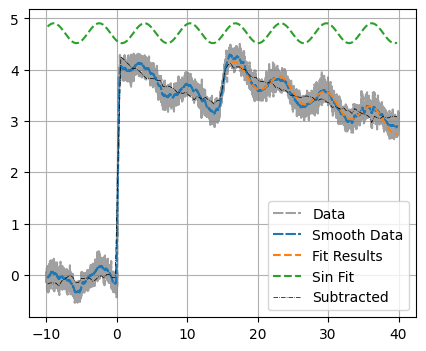

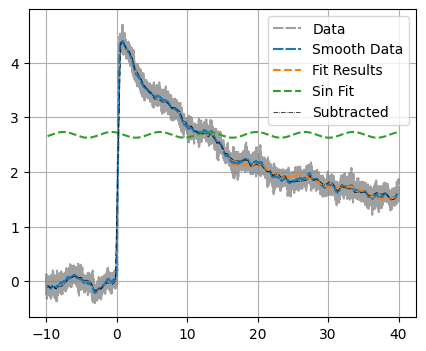

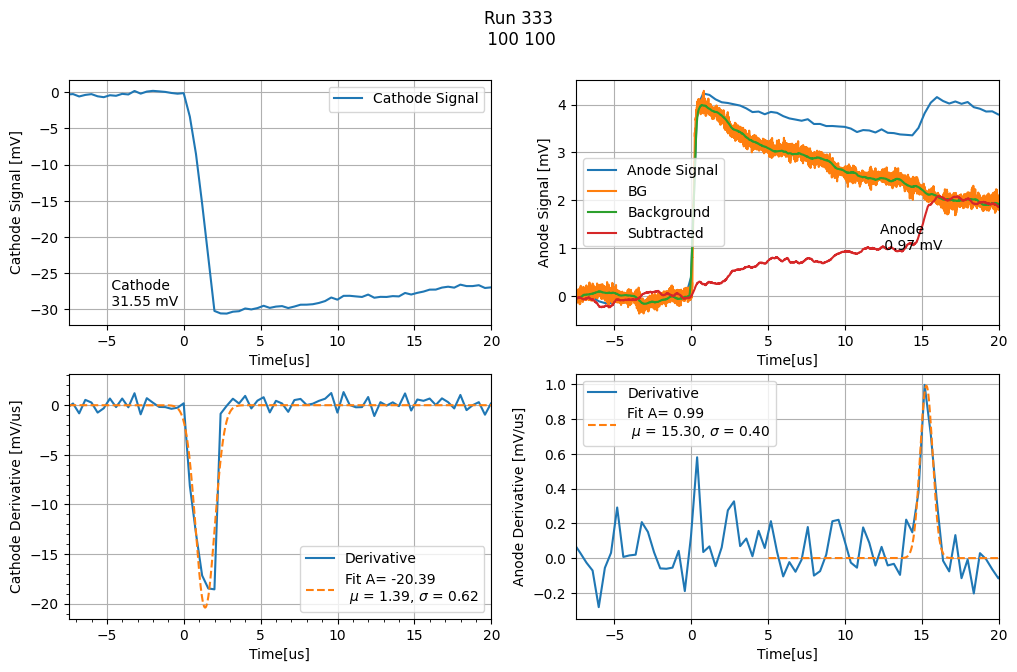

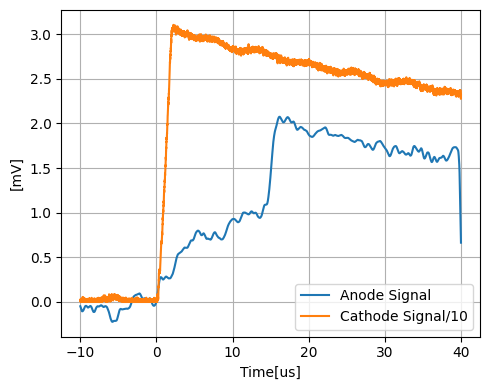

In [30]:
Run333=AnalyzeRun([333],[100],[100],debug=6, plot=True)

Run333=DV_ana(Run333)
Run333=LT_ana(Run333)



# Analysis discussion
## 1. Runlist import


In [13]:
ReadRunlist

<function __main__.ReadRunlist(filename='C:/Users/jasonbane/Desktop/nexo_code/Run Data (GUI v1)/RunList.csv')>

In [15]:
ReadRunlist().head()

,Run No.,Configuration No.,Date,Grid No.,Run Type,Anode V.,Anode Grid V.,Cathode V.,Cathode Grid V.,Laser Current,...,Media,Target Channel,Target Temp.,Target Pressure,RTD 1,RTD 2,RTD 3,Window,Drift Length,Notes
0,4,12,20240710,Double Grid,Test,200.0,450,28.0,1000.0,Vacuum,...,0,0,181.9,197.0,197.0,50.0,8.0,NaN,NaN,NaN
1,6,112,20240801,Double Grid,Production,200.0,0,600.0,400.0,26,...,Vacuum,1,NaN,NaN,199.0,189.0,179.0,200.0,8.0,Vacuum data
2,7,112,20240801,Double Grid,Production,200.0,0,600.0,400.0,24,...,Vacuum,1,NaN,NaN,199.0,189.0,179.0,100.0,8.0,Vacuum data
3,8,112,20240801,Double Grid,Production,200.0,0,600.0,400.0,23,...,Vacuum,1,NaN,NaN,199.0,189.0,179.0,100.0,8.0,Vacuum data
4,9,112,20240801,Double Grid,Production,200.0,0,600.0,400.0,27,...,Vacuum,1,NaN,NaN,199.0,189.0,179.0,100.0,8.0,Vacuum data


In [14]:
Runlist_DF.head()

,Run No.,Configuration No.,Date,Grid No.,Run Type,Anode V.,Anode Grid V.,Cathode V.,Cathode Grid V.,Laser Current,...,Collection Distance Error,Cathode Preamp Gain,Cathode Preamp Error,Anode Preamp Gain,Anode Preamp Error,Drift Field,Extraction Field,Collection Field,Drift Distance,Drift Distance Error
0,4,12,20240710,Double Grid,Test,200.0,450,28.0,1000.0,Vacuum,...,0.0060,0.656,0.001,0.708,0.001,265.828903,-inf,-4901.960784,21.2000,0.080225
1,6,112,20240801,Double Grid,Production,200.0,0,600.0,400.0,26,...,0.0058,0.656,0.001,0.708,0.001,444.444444,2459.117177,2459.117177,10.6266,0.150224
2,7,112,20240801,Double Grid,Production,200.0,0,600.0,400.0,24,...,0.0058,0.656,0.001,0.708,0.001,444.444444,2459.117177,2459.117177,10.6266,0.150224
3,8,112,20240801,Double Grid,Production,200.0,0,600.0,400.0,23,...,0.0058,0.656,0.001,0.708,0.001,444.444444,2459.117177,2459.117177,10.6266,0.150224
4,9,112,20240801,Double Grid,Production,200.0,0,600.0,400.0,27,...,0.0058,0.656,0.001,0.708,0.001,444.444444,2459.117177,2459.117177,10.6266,0.150224


## Get the waveform data

In [16]:
GetWaveForm

<function __main__.GetWaveForm(runnumber, wavenumber=9)>

In [21]:
GetWaveForm(635,2005)

,Time,Channel Trigger,Channel Cathode,Channel Anode,Avg Cathode,Avg Anode
0,-5.008000,0.00000,47.61319,20.52165,-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞...,21.26380
1,-5.004000,0.00000,39.67766,17.36589,-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞...,21.19253
2,-5.000000,0.00000,39.67766,18.94685,-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞...,21.03153
3,-4.996000,0.00000,47.61319,18.94685,-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞...,21.10884
4,-4.992000,-39.52387,55.57948,17.36589,-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞...,21.10881
...,...,...,...,...,...,...
12498,44.983999,0.00000,-103.19270,18.94685,-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞...,19.77148
12499,44.987999,0.00000,-95.25713,17.36589,-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞...,19.88602
12500,44.991999,0.00000,-111.15900,17.36589,-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞...,19.95727
12501,44.995999,-39.52387,-127.03000,17.36589,-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞-∞...,19.82104


## Anode off background run
## removing sinusoidal background

In [25]:
GetBGRun

<function __main__.GetBGRun(run)>

In [27]:
GetBGRun(500),GetBGRun(333)

(-1, 338)

Start  27 6750  stop  50 12500
Fit P0 [1.3759002000000002, 0.15, 0.1, -0.1, 2]
Bounds ([-1, 0.001, -3.141592653589793, -5, -10], [2.3759002000000002, 1.5, 3.141592653589793, 5, 1000])
Parameters [ 0.18595107  0.15612204 -2.48303015 -0.04347019 32.6174798 ]
Covariance [[ 1.22769651e-06 -8.89880852e-09  1.64216806e-06  2.44680181e-09
  -3.22361526e-08]
 [-8.89880852e-09  2.49828282e-08 -4.43002543e-06  7.14199290e-09
  -2.04841248e-07]
 [ 1.64216806e-06 -4.43002543e-06  8.21836111e-04 -1.27572970e-06
   3.71624705e-05]
 [ 2.44680181e-09  7.14199290e-09 -1.27572970e-06  1.64899083e-08
  -4.70216843e-07]
 [-3.22361526e-08 -2.04841248e-07  3.71624705e-05 -4.70216843e-07
   1.40328658e-05]]
Fit deviation from fitting data 0.03975229796069848



Start  26 6499  stop  50 12499
Fit P0 [0.7405149999999985, 0.15, 0.1, -0.1, 2]
Bounds ([-1, 0.001, -3.141592653589793, -5, -10], [1.7405149999999985, 1.5, 3.141592653589793, 5, 1000])
Parameters [ 5.24594852e-02  1.45923459e-01  2.22743375e+00 -3.0061

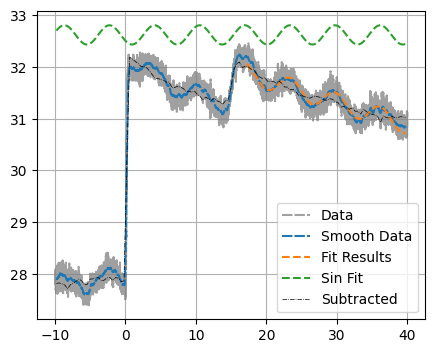

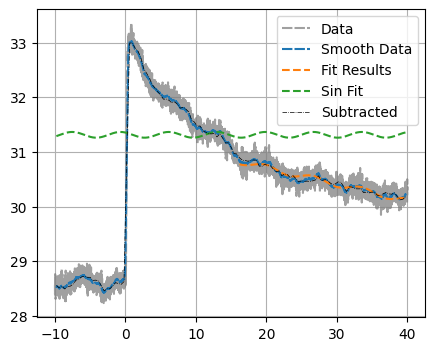

In [40]:
run=333
WF=GetWaveForm(run)
BG_run= GetBGRun(run)
BG_WF= GetWaveForm(BG_run)


a=GetSinBG(WF["Time"], WF["Avg Anode"],27,50,debug=10 )

print("\n\n")
a=GetSinBG(BG_WF["Time"], BG_WF["Avg Anode"], 26,50,debug=10 )